# Animated pyplot figure for jupyter notebooks

In [1]:
import writefile_run

In [2]:
%%writefile_run nb_figure.py

"""Module which extends matplotlib figures to notebooks. 
Figures are displayed as loaded images using IPython display."""

import matplotlib.pyplot as plt
from IPython.display import *
import numpy as np

In [3]:
%%writefile_run nb_figure.py -a


class NBFigure():
    """An extension of matplotlib figure to work with jupyter notebook's display module.
    Works by storing the figure as an image on disk and loading it to display on updating.
    """
    def __init__(self,image_path,nrows=1,ncols=1,decorate_fn=None,**subplot_kwargs):
        """
        image_path: the filename of the stored figure image
        
        Rest of the arguments are indentical to subplots' arguments
        """
        
        self.nrows=nrows
        self.ncols=ncols
        self.fig, self.axes = plt.subplots(nrows,ncols,**subplot_kwargs)
        
        self.axes=self.axes.reshape(nrows,ncols)
        
        if decorate_fn != None:
            decorate_fn(self.axes)
        
        plt.close(self.fig)
        
        
        self.image_path = image_path
        self.fig.savefig(image_path, bbox_inches='tight')
        self.disp = None
        
        self.xlims = [[(None,None) for j in range(ncols)] for i in range(nrows)]
        self.ylims = [[(None,None) for j in range(ncols)] for i in range(nrows)]
        
    def update_lims(self):
        """
        Updates lims of all axes
        """
        for i in range(self.nrows):
            for j in range(self.ncols):
                ax = self.axes[i][j]
                ax.relim()
                ax.autoscale()
                ax.set_xlim(self.xlims[i][j])
                ax.set_ylim(self.ylims[i][j])
                
    def set_xlim(self,xlim,row=0,col=0):
        """Set the xlims of the axes indexed by row and col, starting from 0.
        Effect will be visible only after update."""
        self.xlims[row][col]=xlim

    def set_ylim(self,ylim,row=0,col=0):
        """Set the ylims of the axes indexed by row and col, starting from 0.
        Effect will be visible only after update."""
        self.ylims[row][col]=ylim
        
    def display(self):
        """Create a new display of the figure"""
        self.disp = display(Image(self.image_path),display_id=str(id(self)))
    
    def update(self, update_lims=True):
        """Update the lims(if set to True) and update all display instances"""
        if update_lims:
            self.update_lims()
        self.fig.savefig(self.image_path, bbox_inches='tight')
        self.disp.update(Image(self.image_path))
        
    def plotLine(self,x,y,row=0,col=0,**plot_kwargs):
        """Plot a line and return the Line2D object"""
        l,= self.axes[row][col].plot(x,y,**plot_kwargs)
        return l

# Testing

Demonstrate the phenomenon of aliasing using an animated plot with changing frequency of a sinusoid.

In [4]:
plt.style.use('dark_background')
plt.rcParams['axes.grid']=True
plt.rcParams['font.size']=15

In [5]:
def decorate(axes):
    axes[0][0].set_title("Time domain")
    axes[0][0].set_ylabel("$y$")
    axes[0][0].set_xlabel("$t$")
    
    axes[0][1].set_title("Discrete Fourier Transform")
    axes[0][1].set_xlabel("$\omega$ in radians")
    axes[0][1].set_ylabel("Magnitude")

In [6]:
t_range = (-np.pi,np.pi)
n_samples = 100
sampling_freq = 2*np.pi*n_samples/(t_range[1]-t_range[0])
w_range = (-sampling_freq/2,sampling_freq/2)

t = np.linspace(*t_range,n_samples+1)[:-1]
w = np.linspace(*w_range,n_samples+1)[:-1]

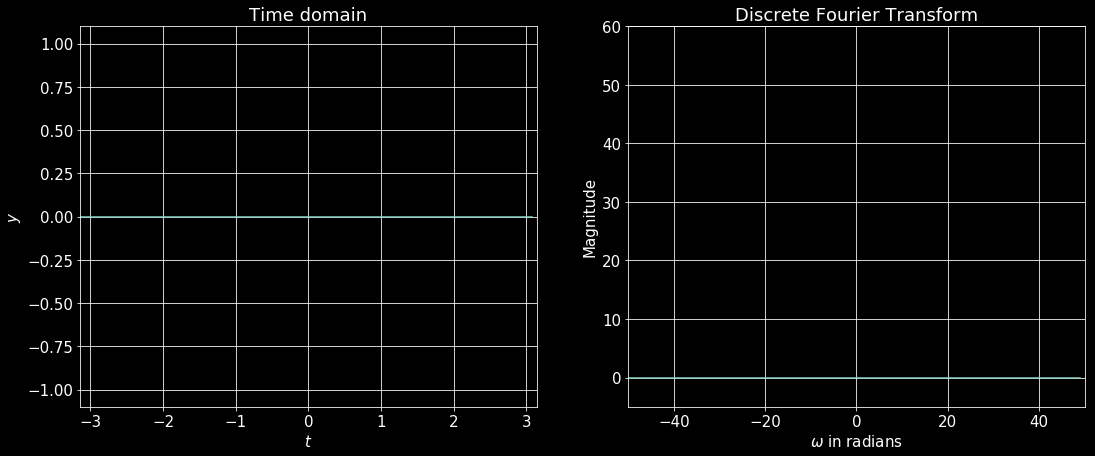

Frequency = 100 rad/s

In [7]:
nbfig = NBFigure('testimage.png',figsize=(18,7),ncols=2,decorate_fn=decorate)
nbfig.set_xlim(t_range)
nbfig.set_xlim(w_range,col=1)
nbfig.set_ylim((-1.1,1.1))
nbfig.set_ylim((-5,60),col=1)
sig = nbfig.plotLine([0],[0])
dft = nbfig.plotLine([0],[0],col=1)
nbfig.display()
nbfig.update()
d = display(Markdown(''),display_id='freq_text')

In [8]:
for freq in range(101):
    y = np.sin(freq*t)
    sig.set_data(t,y)
    d.update(Markdown('Frequency = {} rad/s'.format(freq)))
    df = np.fft.fftshift(np.fft.fft(y))
    dft.set_data(w,abs(df))
    nbfig.update(update_lims=False)